In [53]:
import pandas as pd
from tqdm import tqdm
import os
from typing import List, Dict
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
# Same ordering as paper
task_2_name: Dict[str, str] = {
    # Operational outcomes
    'guo_los': 'Long LOS',
    'guo_readmission': '30-Day Readmission',
    'guo_icu': 'ICU Admission',
    # Anticipating lab test results
    'lab_thrombocytopenia': 'Thrombocytopenia',
    'lab_hyperkalemia': 'Hyperkalemia',
    'lab_hypoglycemia': 'Hypoglycemia',
    'lab_hyponatremia': 'Hyponatremia',
    'lab_anemia': 'Anemia',
    # Assignment of new diagnoses
    'new_hypertension': 'Hypertension',
    'new_hyperlipidemia': 'Hyperlipidemia',
    'new_pancan': 'Pancreatic Cancer',
    'new_celiac': 'Celiac',
    'new_lupus': 'Lupus',
    'new_acutemi' : 'Acute MI',
    # Anticipating chest x-ray findings
    'chexpert' : 'Chest X-Ray',
}

task_2_value_type: Dict[str, str] = {
    'new_pancan': 'boolean',
    'new_celiac': 'boolean',
    'new_lupus': 'boolean',
    'new_acutemi' : 'boolean',
    'new_hypertension': 'boolean',
    'new_hyperlipidemia': 'boolean',
    'guo_los': 'boolean',
    'guo_readmission': 'boolean',
    'guo_icu': 'boolean',
    'lab_thrombocytopenia': 'multiclass',
    'lab_hyperkalemia': 'multiclass',
    'lab_hypoglycemia': 'multiclass',
    'lab_hyponatremia': 'multiclass',
    'lab_anemia': 'multiclass',
    'chexpert' : 'multilabel',
}

In [ ]:
path_to_data_csv = './EHRSHOT_ASSETS/data/ehrshot.csv'
path_to_labels_dir = './EHRSHOT_ASSETS/benchmark/'
path_to_splits_csv = './EHRSHOT_ASSETS/splits/person_id_map.csv'

# Overall Stats

In [4]:
df_dataset = pd.read_csv(path_to_data_csv)
df_split = pd.read_csv(path_to_splits_csv)

/var/folders/h4/1v78m5xj34d9hlchb2rsvndh0000gn/T/ipykernel_19482/1359692343.py:1: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dataset = pd.read_csv(path_to_data_csv)


In [11]:
df_dataset[['patient_id', 'visit_id']].drop_duplicates().groupby('patient_id').size().median()

59.0

In [7]:
print("# of events:", df_dataset.shape[0])
print("# of patients:", df_dataset['patient_id'].nunique())
print("# of visits:", df_dataset['visit_id'].nunique())
print("# of train patients", df_split[df_split['split'] == 'train']['omop_person_id'].nunique())
print("# of val patients", df_split[df_split['split'] == 'val']['omop_person_id'].nunique())
print("# of test patients", df_split[df_split['split'] == 'test']['omop_person_id'].nunique())

# of events: 41661637
# of patients: 6739
# of visits: 921499
# of train patients 2295
# of val patients 2232
# of test patients 2212


# Visit Counts

In [20]:
visit_counts = []
for pid in tqdm(df_dataset['patient_id'].unique()):
    df_events = df_dataset[df_dataset['patient_id'] == pid]
    n_visits: int = df_events['visit_id'].dropna().nunique()
    visit_counts.append((pid, n_visits))
df_visit_counts = pd.DataFrame(visit_counts, columns=['patient_id', 'n_visits'])
df_visit_counts

100%|██████████| 6739/6739 [01:38<00:00, 68.39it/s]


,patient_id,n_visits
0,115973305,448
1,115972510,75
2,115971969,271
3,115971959,574
4,115968144,507
...,...,...
6734,115968110,0
6735,115973183,0
6736,115970439,2
6737,115972800,1


In [21]:
print("# of visits per patient (median):", df_visit_counts['n_visits'].median())
print("# of visits per patient (mean):", df_visit_counts['n_visits'].mean())

# of visits per patient (median): 58.0
# of visits per patient (mean): 136.74120789434633


Text(0.5, 1.0, 'EHRSHOT full dataset (n=6739)')

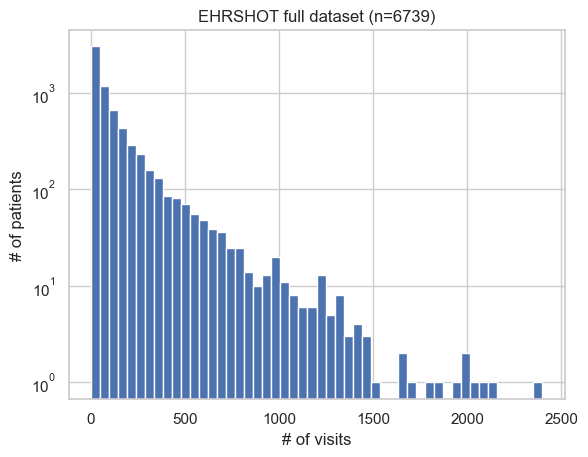

In [54]:
import matplotlib.pyplot as plt
plt.hist(df_visit_counts['n_visits'], bins=50)
plt.ylabel("# of patients")
plt.yscale('log')
plt.xlabel("# of visits")
plt.title(f"EHRSHOT full dataset (n={df_visit_counts.shape[0]})")

# Event Counts

In [30]:
event_counts = []
for pid in tqdm(df_dataset['patient_id'].unique()):
    df_events = df_dataset[df_dataset['patient_id'] == pid]
    n_events: int = df_events.shape[0]
    event_counts.append((pid, n_events))
df_event_counts = pd.DataFrame(event_counts, columns=['patient_id', 'n_events'])
df_event_counts

100%|██████████| 6739/6739 [01:36<00:00, 69.90it/s]


,patient_id,n_events
0,115973305,6481
1,115972510,2549
2,115971969,8615
3,115971959,18738
4,115968144,10297
...,...,...
6734,115968110,13
6735,115973183,24
6736,115970439,16
6737,115972800,10


In [31]:
print("# of events per patient (median):", df_event_counts['n_events'].median())
print("# of events per patient (mean):", df_event_counts['n_events'].mean())

# of events per patient (median): 2592.0
# of events per patient (mean): 6182.169016174506


Text(0.5, 1.0, 'EHRSHOT full dataset (n=6739)')

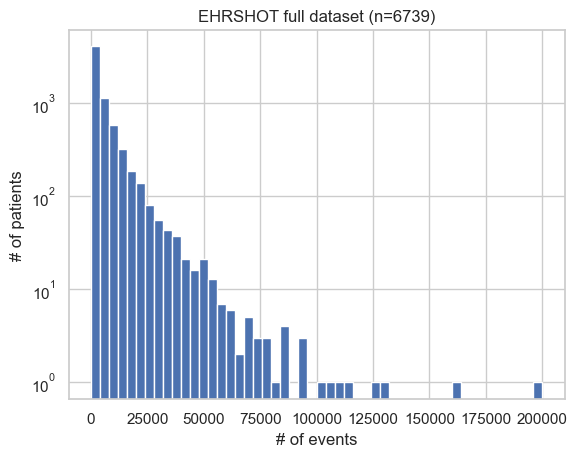

In [55]:
import matplotlib.pyplot as plt
plt.hist(df_event_counts['n_events'], bins=50)
plt.ylabel("# of patients")
plt.yscale('log')
plt.xlabel("# of events")
plt.title(f"EHRSHOT full dataset (n={df_event_counts.shape[0]})")

# Timeline Lengths

In [39]:
timeline_lengths = []
for pid in tqdm(df_dataset['patient_id'].unique()):
    df_ = df_dataset[df_dataset['patient_id'] == pid].sort_values('start', ascending=True)
    first_visit_idx = df_['visit_id'].first_valid_index()
    last_visit_idx = df_['visit_id'].last_valid_index()
    if first_visit_idx is not None and last_visit_idx is not None:
        length: int = pd.to_datetime(df_.loc[last_visit_idx, 'start']) - pd.to_datetime(df_.loc[first_visit_idx, 'start'])
        timeline_lengths.append((pid, length))
df_timeline_lengths = pd.DataFrame(timeline_lengths, columns=['patient_id', 'length'])
df_timeline_lengths

100%|██████████| 6739/6739 [02:01<00:00, 55.49it/s]


,patient_id,length
0,115973305,5245 days 12:14:00
1,115972510,1130 days 12:37:00
2,115971969,4081 days 09:02:00
3,115971959,4076 days 00:00:00
4,115968144,8974 days 08:37:00
...,...,...
6714,115971520,46 days 06:47:00
6715,115967215,549 days 00:00:00
6716,115970439,5 days 09:48:00
6717,115972800,3441 days 12:21:00


In [45]:
print("Years between first and last visit per patient (median):", df_timeline_lengths['length'].median().days / 365.25)
print("Years between first and last visit per patient (mean):", df_timeline_lengths['length'].mean().days / 365.25)

Years between first and last visit per patient (median): 7.780971937029432
Years between first and last visit per patient (mean): 8.63791923340178


Text(0.5, 1.0, 'EHRSHOT patients with at least one visit (n=6719)')

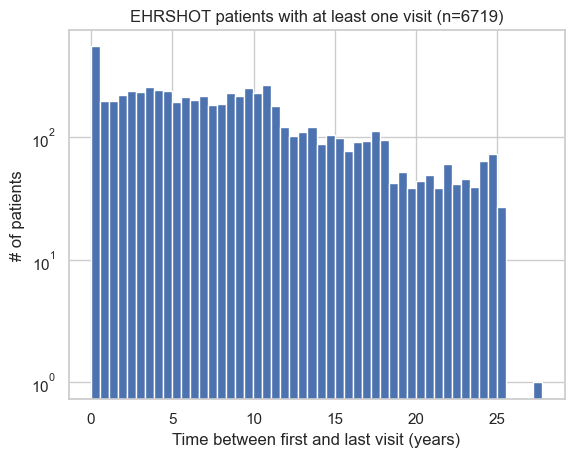

In [56]:
import matplotlib.pyplot as plt
plt.hist(df_timeline_lengths['length'].dt.days / 365.25, bins=50)
plt.ylabel("# of patients")
plt.yscale('log')
plt.xlabel("Time between first and last visit (years)")
plt.title(f"EHRSHOT patients with at least one visit (n={df_timeline_lengths.shape[0]})")

# Label Stats

In [8]:
df_labels = pd.read_csv(os.path.join(path_to_labels_dir, 'all_labels.csv'))

In [9]:
print("# of labels:", df_labels.shape[0])

# of labels: 406379


In [10]:
results = {
    'train' : [],
    'test' : [],
    'val' : [],
    'all' : []
}
for task, task_name in tqdm(task_2_name.items()):
    path_to_task_csv: str = f"{path_to_labels_dir}{task}/labeled_patients.csv"
    if not os.path.exists(path_to_task_csv):
        print(f"Skipping {task_name} @ {path_to_task_csv}")
        continue
    df = pd.read_csv(path_to_task_csv)
    value_type = task_2_value_type[task]
    if task_2_value_type[task] == "boolean":
        df['is_positive_label'] = df["value"]
    elif task_2_value_type[task] == "multiclass":
        df['is_positive_label'] = df["value"] > 0
    elif task_2_value_type[task] == "multilabel":
        df['is_positive_label'] = df["value"] != 8192
    else:
        print(f"Skipping {task_name}")
        continue
    
    # Splits
    for split in ['train', 'test', 'val']:
        df_ = df[df['patient_id'].isin(df_split[df_split['split'] == split]['omop_person_id'])]
        results[split].append({
            'task' : task,
            'task_name' : task_name,
            'n_patients' : df_['patient_id'].nunique(),
            'n_positive_patients' : df_.groupby('patient_id')['is_positive_label'].max().sum(),
            'n_labels' : df_.shape[0],
            'n_positive_labels' : df_['is_positive_label'].sum(),
        })
    
    # All
    results['all'].append({
        'task' : task,
        'task_name' : task_name,
        'n_patients' : df['patient_id'].nunique(),
        'n_positive_patients' : df.groupby('patient_id')['is_positive_label'].max().sum(),
        'n_labels' : df.shape[0],
        'n_positive_labels' : df['is_positive_label'].sum(),
    })

for key in results.keys():
    results[key] = pd.DataFrame(results[key])
    results[key]['n_negative_labels'] = results[key]['n_labels'] - results[key]['n_positive_labels']
    results[key]['n_negative_patients'] = results[key]['n_patients'] - results[key]['n_positive_patients']
    results[key]['label_prevalence'] = results[key]['n_positive_labels'] / results[key]['n_labels']
    results[key] = results[key][['task_name', 'n_patients', 'n_positive_patients', 'n_negative_patients', 'n_labels', 'n_positive_labels', 'n_negative_labels', 'label_prevalence']]

100%|██████████| 15/15 [00:00<00:00, 21.94it/s]


In [11]:
results['all']

,task_name,n_patients,n_positive_patients,n_negative_patients,n_labels,n_positive_labels,n_negative_labels,label_prevalence
0,Long LOS,3855,1271,2584,6995,1767,5228,0.252609
1,30-Day Readmission,3718,474,3244,7003,911,6092,0.130087
2,ICU Admission,3617,266,3351,6491,290,6201,0.044677
3,Thrombocytopenia,6063,2566,3497,179618,59718,119900,0.332472
4,Hyperkalemia,5931,1289,4642,200170,4769,195401,0.023825
5,Hypoglycemia,5974,1379,4595,318164,4721,313443,0.014838
6,Hyponatremia,5921,3692,2229,212837,60708,152129,0.285232
7,Anemia,6086,4271,1815,184880,127496,57384,0.689615
8,Hypertension,2328,386,1942,3764,516,3248,0.137088
9,Hyperlipidemia,2650,410,2240,4442,566,3876,0.127420


In [12]:
# Train
results['train']

,task_name,n_patients,n_positive_patients,n_negative_patients,n_labels,n_positive_labels,n_negative_labels,label_prevalence
0,Long LOS,1377,464,913,2569,681,1888,0.265084
1,30-Day Readmission,1337,164,1173,2608,370,2238,0.141871
2,ICU Admission,1306,107,1199,2402,113,2289,0.047044
3,Thrombocytopenia,2084,906,1178,68776,22714,46062,0.330261
4,Hyperkalemia,2038,456,1582,76349,1829,74520,0.023956
5,Hypoglycemia,2054,511,1543,122108,1904,120204,0.015593
6,Hyponatremia,2035,1294,741,81336,23877,57459,0.293560
7,Anemia,2092,1484,608,70501,49028,21473,0.695423
8,Hypertension,792,129,663,1259,182,1077,0.144559
9,Hyperlipidemia,923,137,786,1684,205,1479,0.121734


In [13]:
# Val
results['val']

,task_name,n_patients,n_positive_patients,n_negative_patients,n_labels,n_positive_labels,n_negative_labels,label_prevalence
0,Long LOS,1240,395,845,2231,534,1697,0.239355
1,30-Day Readmission,1191,159,1032,2206,281,1925,0.127380
2,ICU Admission,1157,84,1073,2052,92,1960,0.044834
3,Thrombocytopenia,1981,807,1174,54504,17867,36637,0.327811
4,Hyperkalemia,1935,428,1507,60168,1386,58782,0.023036
5,Hypoglycemia,1950,433,1517,95488,1449,94039,0.015175
6,Hyponatremia,1930,1174,756,64473,17557,46916,0.272316
7,Anemia,1992,1379,613,56224,38498,17726,0.684725
8,Hypertension,781,128,653,1247,175,1072,0.140337
9,Hyperlipidemia,863,140,723,1441,189,1252,0.131159


In [14]:
# Test
results['test']

,task_name,n_patients,n_positive_patients,n_negative_patients,n_labels,n_positive_labels,n_negative_labels,label_prevalence
0,Long LOS,1238,412,826,2195,552,1643,0.251481
1,30-Day Readmission,1190,151,1039,2189,260,1929,0.118776
2,ICU Admission,1154,75,1079,2037,85,1952,0.041728
3,Thrombocytopenia,1998,853,1145,56338,19137,37201,0.339682
4,Hyperkalemia,1958,405,1553,63653,1554,62099,0.024414
5,Hypoglycemia,1970,435,1535,100568,1368,99200,0.013603
6,Hyponatremia,1956,1224,732,67028,19274,47754,0.287551
7,Anemia,2002,1408,594,58155,39970,18185,0.687301
8,Hypertension,755,129,626,1258,159,1099,0.126391
9,Hyperlipidemia,864,133,731,1317,172,1145,0.130600


In [18]:
print(results['all'].to_markdown(index=False))

| task_name          |   n_patients |   n_positive_patients |   n_negative_patients |   n_labels |   n_positive_labels |   n_negative_labels |   label_prevalence |
|:-------------------|-------------:|----------------------:|----------------------:|-----------:|--------------------:|--------------------:|-------------------:|
| Long LOS           |         3855 |                  1271 |                  2584 |       6995 |                1767 |                5228 |          0.252609  |
| 30-Day Readmission |         3718 |                   474 |                  3244 |       7003 |                 911 |                6092 |          0.130087  |
| ICU Admission      |         3617 |                   266 |                  3351 |       6491 |                 290 |                6201 |          0.0446772 |
| Thrombocytopenia   |         6063 |                  2566 |                  3497 |     179618 |               59718 |              119900 |          0.332472  |
| Hyperkalemia  

In [15]:
print(results['train'].to_markdown(index=False))

| task_name          |   n_patients |   n_positive_patients |   n_negative_patients |   n_labels |   n_positive_labels |   n_negative_labels |   label_prevalence |
|:-------------------|-------------:|----------------------:|----------------------:|-----------:|--------------------:|--------------------:|-------------------:|
| Long LOS           |         1377 |                   464 |                   913 |       2569 |                 681 |                1888 |          0.265084  |
| 30-Day Readmission |         1337 |                   164 |                  1173 |       2608 |                 370 |                2238 |          0.141871  |
| ICU Admission      |         1306 |                   107 |                  1199 |       2402 |                 113 |                2289 |          0.0470441 |
| Thrombocytopenia   |         2084 |                   906 |                  1178 |      68776 |               22714 |               46062 |          0.330261  |
| Hyperkalemia  

In [16]:
print(results['val'].to_markdown(index=False))

| task_name          |   n_patients |   n_positive_patients |   n_negative_patients |   n_labels |   n_positive_labels |   n_negative_labels |   label_prevalence |
|:-------------------|-------------:|----------------------:|----------------------:|-----------:|--------------------:|--------------------:|-------------------:|
| Long LOS           |         1240 |                   395 |                   845 |       2231 |                 534 |                1697 |         0.239355   |
| 30-Day Readmission |         1191 |                   159 |                  1032 |       2206 |                 281 |                1925 |         0.12738    |
| ICU Admission      |         1157 |                    84 |                  1073 |       2052 |                  92 |                1960 |         0.0448343  |
| Thrombocytopenia   |         1981 |                   807 |                  1174 |      54504 |               17867 |               36637 |         0.327811   |
| Hyperkalemia  

In [17]:
print(results['test'].to_markdown(index=False))

| task_name          |   n_patients |   n_positive_patients |   n_negative_patients |   n_labels |   n_positive_labels |   n_negative_labels |   label_prevalence |
|:-------------------|-------------:|----------------------:|----------------------:|-----------:|--------------------:|--------------------:|-------------------:|
| Long LOS           |         1238 |                   412 |                   826 |       2195 |                 552 |                1643 |         0.251481   |
| 30-Day Readmission |         1190 |                   151 |                  1039 |       2189 |                 260 |                1929 |         0.118776   |
| ICU Admission      |         1154 |                    75 |                  1079 |       2037 |                  85 |                1952 |         0.041728   |
| Thrombocytopenia   |         1998 |                   853 |                  1145 |      56338 |               19137 |               37201 |         0.339682   |
| Hyperkalemia  